**SECTION OBJECTIVES**
* Improving Bankruptcy model using `GRADIENT BOOSTING`
* Evaluating model using `PRECISION` and `RECALL`
* Creating an `INTERACTIVE DASHBOARD`
* Creating a `Python Module` to store Prediction Function

**ML WORKFLOW**
* PREPARING DATA
    * Importing
    * Exploring
    * Splitting
    * Resampling
* BUILDING MODEL
    * Baselining
    * Iterating: **Gradient Boosting, Grid Search**
        * `Boosting`
        * `Weak Learner`: A decision Tree which by itself is not enough
    * Evaluating: **Precision, Recall, Dashboard**
        * **Positive (Companies which go Bankrupt) and Negative Class (Companies which do not go bankrupt)**
        * **False Negatives and False Positives (where the model falsely predicts a healthy company to go bankrupt)**
BUT it INCREASES the number of FALSE NEGATIVES (where the model falsely predicts a failing company to NOT go bankrupt. to survive)
* COMMUNICATING RESULTS
    * Saving model as file
    * Building `my_predictor` Module

In [29]:
# importing necessary libraries

import json
import pickle

import ipywidgets as widgets 
from ipywidgets import interact # For interactive dashboard

import matplotlib.pyplot as plt
import pandas as pd

from imblearn.over_sampling import RandomOverSampler

from sklearn.ensemble import GradientBoostingClassifier # The ensemble model
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix # Classification Report for calculating precision and recall
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline

# 1. Preparing Data
## 1.1 Importing Data

In [2]:
def wrangle(filename):
    # Opening json file and loading it into dictionary
    with open(filename, 'r') as f:
        data = json.load(f)
    
    # Loading dictionary into a DataFrame and setting index as `company_id`
    df = pd.DataFrame().from_dict(data['data']).set_index('company_id')
    
    return df

In [3]:
# Running wrangle function
df = wrangle('poland-bankruptcy-data-2009.json')
print(df.shape)
df.head()

(9977, 65)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,bankrupt
company_id,,,,,,,,,,,,,,,,,,,,,
1,0.174190,0.41299,0.14371,1.3480,-28.9820,0.60383,0.219460,1.12250,1.1961,0.46359,...,0.163960,0.375740,0.83604,0.000007,9.7145,6.2813,84.291,4.3303,4.0341,False
2,0.146240,0.46038,0.28230,1.6294,2.5952,0.00000,0.171850,1.17210,1.6018,0.53962,...,0.027516,0.271000,0.90108,0.000000,5.9882,4.1103,102.190,3.5716,5.9500,False
3,0.000595,0.22612,0.48839,3.1599,84.8740,0.19114,0.004572,2.98810,1.0077,0.67566,...,0.007639,0.000881,0.99236,0.000000,6.7742,3.7922,64.846,5.6287,4.4581,False
5,0.188290,0.41504,0.34231,1.9279,-58.2740,0.00000,0.233580,1.40940,1.3393,0.58496,...,0.176480,0.321880,0.82635,0.073039,2.5912,7.0756,100.540,3.6303,4.6375,False
6,0.182060,0.55615,0.32191,1.6045,16.3140,0.00000,0.182060,0.79808,1.8126,0.44385,...,0.555770,0.410190,0.46957,0.029421,8.4553,3.3488,107.240,3.4036,12.4540,False


## 1.3 Splitting Data
### Vertical Splitting

In [4]:
target = 'bankrupt'
X = df.drop(columns = target)
y = df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (9977, 64)
y shape: (9977,)


### Horizontal Splitting (Randomised Train-Test Split)

In [5]:
# Performing a randomised train-test split (80:20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (7981, 64)
y_train shape: (7981,)
X_test shape: (1996, 64)
y_test shape: (1996,)


## 1.4 Resampling Data
### Over-Sampling

In [6]:
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)

print(X_train_over.shape)
X_train_over.head()

(15194, 64)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64
0,0.279320,0.053105,0.852030,17.0440,199.080,0.741770,0.353570,16.00600,1.2346,0.84997,...,52857.00,0.190040,0.328630,0.80996,0.00000,NaN,4.1858,11.002,33.1760,18.5720
1,0.001871,0.735120,0.156460,1.2269,-10.837,0.000000,0.002938,0.36032,1.4809,0.26488,...,440.02,0.014794,0.007064,0.99803,0.00000,7.4268,2.2925,169.960,2.1476,9.6185
2,0.113940,0.490250,0.077121,1.2332,-43.184,-0.000171,0.113940,1.03980,1.1649,0.50975,...,4617.40,0.214890,0.223520,0.78761,0.27412,6.2791,6.1622,103.630,3.5220,1.9673
3,0.008136,0.652610,0.148120,1.2628,29.071,0.000000,0.008136,0.53230,1.2891,0.34739,...,920.98,0.045169,0.023421,0.99434,0.14403,22.7480,2.2673,159.580,2.2872,4.4718
4,0.045396,0.279640,0.708730,3.7656,238.120,0.000000,0.056710,2.57610,1.0169,0.72036,...,10744.00,0.047501,0.063019,0.94624,0.00000,13.8860,49.0660,91.984,3.9681,29.0460


# 2. Building Model
## 2.1 Baselining
### Baseline Accuracy Score

In [7]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.9519


## 2.2 Iterating
### Gradient Boosting Trees
* Random Forest are an example of Bagging, where multiple models are fitted in parallel on subsets of data
* In a `Boosting` model, multiple models are fitted in sequence using all of the Training Data
* STEP 1:
    * Fit a decision tree to training data. This decision tree is a `weak learner` i.e. it is not so good at making predictions
    * After fitting, residuals are calculated for this tree. The set of residuals R1 is obtained
* STEP 2:
    * A second tree is fitted on the residuals of previous tree. 
    * Tree2 is trying to predict how far from actual values were the predictions of Tree1, so that it can improve on those predictions
    * Residuals are calculated again. This time we are looking at difference between true residuals of tree1 and Tree2 predictions of those residuals
    * This new set of residuals is R2
* STEP 3:
    * The process is repeated with a Tree3, and residuals are calculated again
* STEP 4:
    * This process is repeated 100 times by default in scikit learn. 
    * Everytime the model adds a new tree, it improves upon the previous tree's prediction
    * What we end up with is an ensemble of weak learners chained together, each improving on the last one. This ends up improving predictions
* **Remember that in Boosting we are fitting multiple models in sequence on all of Training Data**

In [8]:
# Creating a pipeline clf (short for "classifier") that contains a SimpleImputer transformer and a GradientBoostingClassifier predictor

clf = make_pipeline(SimpleImputer(), GradientBoostingClassifier()) 

### Hyperparameter Grid
* Creating a dictionary with the range of hyperparameters to evaluate for classifier. 

1. For the `SimpleImputer`, trying both the `"mean"` and `"median"` strategies. 
2. For the `GradientBoostingClassifier`, experimenting with `max_depth` settings between 2 and 5. 
    * When gradient boosting, it is better to keep trees shallow
3. For the `GradientBoostingClassifier`, iterating `n_estimators` settings between 20 and 96, by steps of 5.
4. `learning_rate` in `GradientBoostingClassifier` shrinks the contribution of each tree by that amount(float). There is a trade-off between learning_rate and n_estimators

In [12]:
# Initiating params dictionary
params = {
    'simpleimputer__strategy': ['mean', 'median'],
    'gradientboostingclassifier__n_estimators': range(81, 104, 5),
    'gradientboostingclassifier__max_depth': range(2,5)
}
params

{'simpleimputer__strategy': ['mean', 'median'],
 'gradientboostingclassifier__n_estimators': range(81, 104, 5),
 'gradientboostingclassifier__max_depth': range(2, 5)}

### Grid Search Cross Validation

In [13]:
model = GridSearchCV(clf, param_grid=params, cv = 5, verbose = 1, n_jobs = -1)

### Fitting Model

In [14]:
# Fitting model to over-sampled training data
model.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__max_depth': range(2, 5),
                         'gradientboostingclassifier__n_estimators': range(81, 104, 5),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

### Cross Validation Results

In [15]:
results = pd.DataFrame(model.cv_results_)
results.sort_values("rank_test_score").head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gradientboostingclassifier__max_depth,param_gradientboostingclassifier__n_estimators,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
28,37.621414,0.804448,0.021060,0.005597,4,101,mean,"{'gradientboostingclassifier__max_depth': 4, '...",0.981902,0.970714,0.973346,0.975321,0.977946,0.975846,0.003846,1
29,34.245321,1.169265,0.015109,0.003084,4,101,median,"{'gradientboostingclassifier__max_depth': 4, '...",0.976966,0.973346,0.971701,0.973346,0.977617,0.974595,0.002291,2
26,36.608969,0.471304,0.019779,0.005434,4,96,mean,"{'gradientboostingclassifier__max_depth': 4, '...",0.981244,0.969727,0.971043,0.973346,0.975313,0.974135,0.004038,3
27,36.077067,0.170725,0.021168,0.005278,4,96,median,"{'gradientboostingclassifier__max_depth': 4, '...",0.974663,0.971372,0.970714,0.974334,0.974325,0.973082,0.001682,4
24,34.265055,0.294500,0.018215,0.001335,4,91,mean,"{'gradientboostingclassifier__max_depth': 4, '...",0.980257,0.967423,0.969069,0.969398,0.973996,0.972029,0.004657,5
25,34.581021,0.589098,0.020740,0.004372,4,91,median,"{'gradientboostingclassifier__max_depth': 4, '...",0.972688,0.968740,0.969398,0.969069,0.973009,0.970581,0.001866,6
22,31.838429,0.252722,0.020316,0.003530,4,86,mean,"{'gradientboostingclassifier__max_depth': 4, '...",0.979928,0.963475,0.966765,0.968411,0.971692,0.970054,0.005603,7
23,31.990448,0.237310,0.019141,0.002905,4,86,median,"{'gradientboostingclassifier__max_depth': 4, '...",0.970385,0.963475,0.964133,0.969727,0.968729,0.967290,0.002902,8
20,29.709815,0.256207,0.018187,0.002112,4,81,mean,"{'gradientboostingclassifier__max_depth': 4, '...",0.973676,0.964462,0.963804,0.962159,0.968400,0.966500,0.004132,9
21,30.179651,0.238838,0.022149,0.007186,4,81,median,"{'gradientboostingclassifier__max_depth': 4, '...",0.966107,0.959855,0.962488,0.968082,0.966754,0.964657,0.003033,10


* It can be seen that mean_fit_time is much longer for Gradient Boosting Model compared to the Random Forest Model
* But the accuracy is not better than Random Forest
* It could be the case that this model is just not that good for our case

### Best Hyperparameters
* Extracting best hyperparameters for model

In [16]:
model.best_params_

{'gradientboostingclassifier__max_depth': 4,
 'gradientboostingclassifier__n_estimators': 101,
 'simpleimputer__strategy': 'mean'}

In [17]:
model.best_score_

0.9758458667994153

## 2.3 Evaluating Model
### Calculating Accuracy Scores for model

In [18]:
acc_train = model.score(X_train, y_train)
acc_test = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 0.9727
Test Accuracy: 0.9429


In [19]:
# Counting positive and negative classes in test set
y_test.value_counts()

False    1913
True       83
Name: bankrupt, dtype: int64

### Confusion Matrix

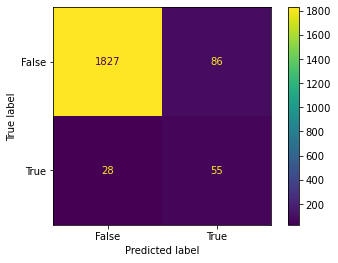

In [20]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);

* It can be observed that compared to Random Forest model, the **FALSE POSITIVES** have **INCREASED** 
    * (where the model falsely predicts a healthy company to go bankrupt)
* **FALSE NEGATIVES** have **DECREASED** as compared to a Random Forest Model
    * (where the model falsely predicts a failing company to NOT go bankrupt. to survive)

### A Note on Accuracy Scores
* This matrix is a great reminder of how imbalanced this data is, and of why accuracy isn't always the best metric for judging whether or not a model is giving us what we want. After all, if 95% of the companies in our dataset didn't go bankrupt, all the model has to do is always predict {"bankrupt": False}, and it'll be right 95% of the time. The accuracy score will be amazing, but it won't tell us what we really need to know.

* Instead, we can evaluate our model using **two new metrics: Precision and Recall**. 
    * **PRECISION SCORE** is important when we want our model to only predict that a company will go bankrupt if its very confident in its prediction. 
    * **RECALL SCORE** is important to identify all the companies that will go bankrupt, even if that means being incorrect sometimes.


### Classification Report

In [21]:
# Printing Classification report
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

       False       0.98      0.96      0.97      1913
        True       0.39      0.66      0.49        83

    accuracy                           0.94      1996
   macro avg       0.69      0.81      0.73      1996
weighted avg       0.96      0.94      0.95      1996



* **Support** Column at the end shows how many observations are in the dataset, and how many observations were used to calculate particular metrics
* **Accuracy** for this model is 0.94 and it was calculated with 1996 observations
* **F1-score** combines the precision and recall of a classifier into a single metric by taking their harmonic mean
* Need to be really sure about what class is Positive and which one is Negative
    * Here we are calculating Precision metrics from the perspective of True which is our Positive Class (that a company will go bankrupt)

* 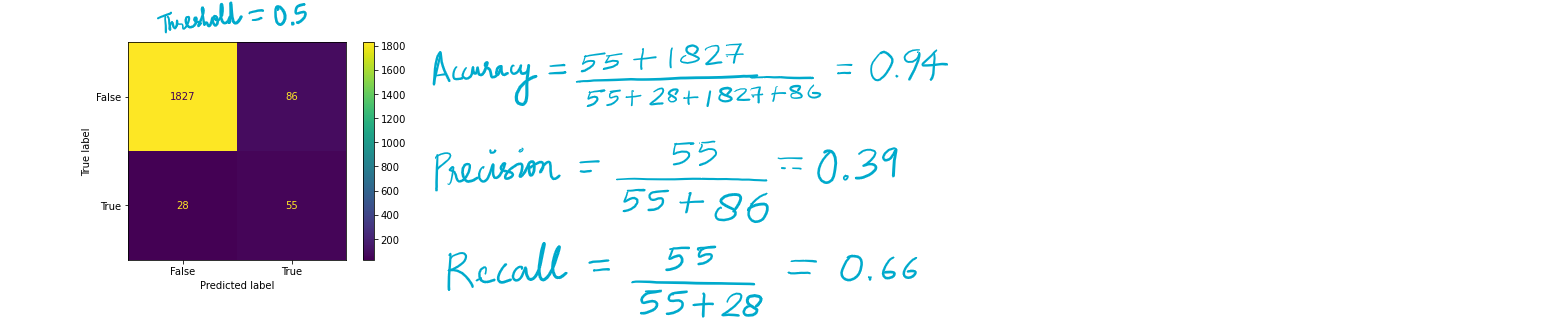
* Threshold means where we are setting the probability cutoff for deciding what belongs to True or False

### Recall Score
* It measures how well the model identifies observations that belong to **POSITIVE CLASS**
* **High Recall -> you want to catch em all**
* For this case, it means of all companies in our test set which actually went bankrupt, what fraction did our model correctly predict going bankrupt
    * If Recall = 1, model identified all companies which went bankrupt
* Lower the probability threshold to increase the model's Recall Score

#### When Recall is more important than Precision
* The regulatory agency in the European Union, e.g., that assists companies and investors navigate [insolvency proceedings](https://en.wikipedia.org/wiki/Insolvency_Regulation) may want to build a model to predict which companies could go bankrupt so that it can send debtors information about filing for legal protection before their company becomes insolvent. 
* The administrative costs of sending information to a company is €500. 
* The legal costs to the European court system if a company doesn't file for protection before bankruptcy is €50,000.
* For a model like this, they'd want to focus on **recall**, because recall is all about *quantity*. 
* A model that prioritizes recall will cast the widest possible net, which is the way to approach this problem. 
* They might want to send information to as many potentially-bankrupt companies as possible, because it costs a lot less to send information to a company that might not become insolvent than it does to skip a company that does. 

### Precision Score
* It measures how well the model identifies observations that belong to POSITIVE CLASS **WITHOUT** making the error of FALSE POSITIVE
* **High Precision -> Make a Careful Decision**
* For this case, precision is the fraction of the companies in our test set which actually went bankrupt from all companies which the model predicted to go bankrupt
* For every False Positive, the precision score will go down
* Increase the probability threshold to increase the model's Precision Score
* The higher we raise the threshold, the higher the number of False Negatives become
* The Cost of high Precision is lower Recall
* Job of the Data Scientist is to determine whether we want higher Precision or higher Recall
    * It would depend on the function and setting where model is expected to perform

#### When Precision is more important than Recall

* Consider a private equity firm that purchases distressed businesses, improve them, and then sells them for a profit
* They want to build a model to predict which companies will go bankrupt so that they can purchase them ahead of competitors
* If the firm purchases a company that is indeed insolvent, it can make a profit of €100 million or more
* But if it purchases a company that isn't insolvent and can't be resold at a profit, the firm will lose €250 million
* For a model like this, they would want to focus on **precision**
* If they are trying to maximize their profit, the *quality* of predictions is much more important than the *quantity* of predictions
* It's not a big deal if they don't catch every single insolvent company, but it's *definitely* a big deal if the companies they catch don't end up becoming insolvent

####  Confusion Matrix Widget 
* **where Precision more important than Recall**
* e.g for a Private Equity firm in example above

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.05), Output()), _dom_cla…

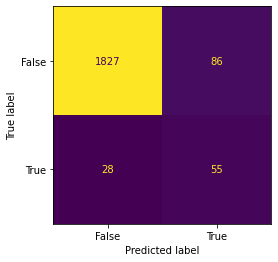

In [26]:
def make_cnf_matrix(threshold):
    y_pred_proba = model.predict_proba(X_test)[:, -1]
    y_pred = y_pred_proba > threshold
    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    print(f'Profits: €{tp * 100_000_000}')
    print(f'Losses: €{fp * 250_000_000}')
    print(f'NET: €{tp * 100_000_000 - fp * 250_000_000}')
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, colorbar = False)
    
thresh_widget = widgets.FloatSlider(min = 0, max = 1, value = 0.5, step = 0.05)

interact(make_cnf_matrix, threshold = thresh_widget);

# 3. Communicating Results
## 3.1 Extracting Feature Importances

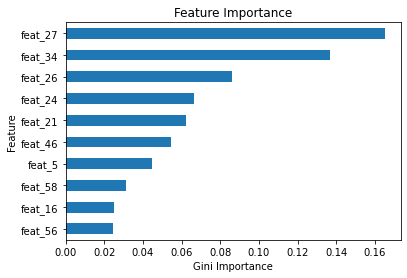

In [30]:
# Getting feature names from training data
features = X_train_over.columns

# Extracting importances from model
importances = model.best_estimator_.named_steps['gradientboostingclassifier'].feature_importances_

# Creating a series with feature names and importances
feat_imp = pd.Series(importances, index = features).sort_values()

# Plotting 10 most important features
feat_imp.tail(10).plot(kind = 'barh')

plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importance");

## 3.2 Saving Model

In [31]:
with open('model-gradient-boosting.pkl', 'wb') as f:
    pickle.dump(model, f)

## 3.3 Predictor Module
* Using a .py predictor module to make predicctions

In [42]:
# Importing module
from predictor import make_predictions

# Generating predictions
y_test_pred = make_predictions(
    data_filepath = 'poland-bankruptcy-data-2009-mvp-features.json',
    model_filepath = 'model-gradient-boosting.pkl',
)

print('predictions shape:', y_test_pred.shape)
y_test_pred.head()

predictions shape: (526,)


company_id
4     False
32    False
34    False
36    False
40     True
Name: bankrupt, dtype: bool